# 04 - Model Comparison: Mileage Parameterizations

This notebook compares three approaches to modeling age and mileage effects on price,
all using partial pooling (random intercepts) on categorical predictors.

**Model comparison:**
| Model | Age | Mileage | Description |
|-------|-----|---------|-------------|
| **Linear Mileage** | linear + random slope by gen | `mileage_scaled` + `is_low_mileage` | Z-scored mileage with binary indicator |
| **Log Mileage** | linear + random slope by gen | `log_mileage` | Natural log captures diminishing returns |
| **Spline** | `bs(age, df=6)` | `bs(log_mileage, df=6)` | Flexible nonlinear effects |

In [1]:
import logging
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from price_analysis.data.cleaning import prepare_model_data
from price_analysis.models import (
    build_model,
    build_spline_model,
    compare_models_loo,
    compare_residual_stats,
    fit_model,
    fit_spline_model,
    get_residuals,
    plot_residual_diagnostics,
    plot_spline_effects_grid,
)
from price_analysis.models.hierarchical import check_diagnostics, predict_price
from price_analysis.models.spline import predict_spline_price

logging.basicConfig(level=logging.INFO)
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
DATA_DIR = Path("../data")
PROCESSED_PATH = DATA_DIR / "processed" / "cleaned_listings.parquet"

## Load and Prepare Data

In [3]:
df_cleaned = pd.read_parquet(PROCESSED_PATH)
df = prepare_model_data(df_cleaned, group_trims=True, group_trans=True)

MILEAGE_MEAN, MILEAGE_STD = df_cleaned["mileage"].mean(), df_cleaned["mileage"].std()

print(f"Model data: {len(df)} listings")
print(f"Age range: {df['age'].min()} - {df['age'].max()} years")
print(
    f"Mileage range (scaled): {df['mileage_scaled'].min():.2f} - {df['mileage_scaled'].max():.2f}"
)

INFO:price_analysis.data.cleaning:Grouped trims into tiers: {'sport': 392, 'base': 360, 'turbo': 272, 'gt': 148, 'gts': 100, 'rs': 88}
INFO:price_analysis.data.cleaning:Grouped transmissions into types: {'manual': 790, 'pdk': 476, 'auto': 94}
INFO:price_analysis.data.cleaning:Model-ready dataset: 1360 listings (from 1615 cleaned)


Model data: 1360 listings
Age range: 0.0 - 26.0 years
Mileage range (scaled): -1.05 - 5.03


## Build Spline Model

In [4]:
AGE_DF = 6  # Degrees of freedom for age spline
MILEAGE_DF = 6  # Degrees of freedom for mileage spline (reduced from 8)
INCLUDE_SALE_YEAR = False  # ≈all 2025 listings
TARGET_ACCEPT = 0.975

In [5]:
spline_model = build_spline_model(
    df,
    age_df=AGE_DF,
    mileage_df=MILEAGE_DF,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_color=True,
)
print(spline_model)

INFO:price_analysis.models.spline:Spline model formula: log_price ~ 1 + bs(age, df=6) + bs(log_mileage, df=6) + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
INFO:price_analysis.models.spline:Built spline model with 1360 observations


       Formula: log_price ~ 1 + bs(age, df=6) + bs(log_mileage, df=6) + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.3507, sigma: 6.2642)
            bs(age, df=6) ~ Normal(mu: [0. 0. 0. 0. 0. 0.], sigma: [ 9.2511 10.0497  9.3571  8.6183 10.6608
                8.5219])
            bs(log_mileage, df=6) ~ Normal(mu: [0. 0. 0. 0. 0. 0.], sigma: [20.3222 11.5633  7.6549  8.5862
                13.3709 33.7529])
        
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|body_style ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|color

## Fit Spline Model

In [6]:
%%time
idata_spline = fit_spline_model(
    spline_model,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.spline:Fitting spline model: 1000 draws, 1000 tune, 8 chains
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, bs(age, df=6), bs(log_mileage, df=6), 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, bs(age, df=6), bs(log_mileage, df=6), 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 116 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 116 seconds.
INFO:price_analysis.models.spline:Model summary:
                            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma                      0.193  0.004   0.186    0.200      0.000    0.000   
Intercept                 12.411  0.318  11.837   13.028      0.005    0.004   
bs(age, df=6)[0]           0.042  0.092  -0.128    0.219      0.001    0.001   
bs(age, df=6)[1]           0.160  0.110  -0.049    0.362      0.001    0.001   
bs(age, df=6)[2]          -0.347  0.112  -0.552   -0.136      0.002    0.001   
bs(age, df=6)[3]          -0.530  0.116  -0.747   -0.308      0.002    0.001   
bs(age, df=6)[4]          -0.786  0.131  -1.022   -0.537      0.002    0.002   
bs(age, df=6)[5]          -0.744  0.125  -0.960   -0.500      0.002    0.002 

CPU times: user 8.6 s, sys: 868 ms, total: 9.47 s
Wall time: 2min 3s


## Diagnostics

In [7]:
diagnostics = check_diagnostics(idata_spline)
print(f"Converged: {diagnostics['converged']}")
print(f"Divergences: {diagnostics['n_divergences']}")
print(f"Max R-hat: {diagnostics['rhat_max']:.3f}")
print(f"Min ESS (bulk): {diagnostics['ess_bulk_min']:.0f}")
if diagnostics["issues"]:
    print(f"Issues: {diagnostics['issues']}")

Converged: True
Divergences: 0
Max R-hat: 1.000
Min ESS (bulk): 2607


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>]], dtype=object)

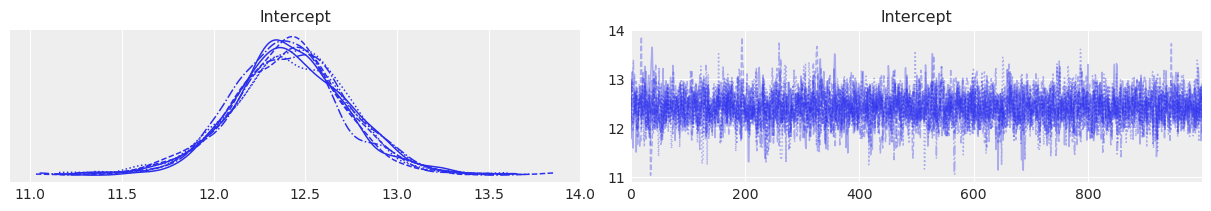

In [8]:
var_names = ["Intercept"]
az.plot_trace(idata_spline, var_names=var_names)

## Visualize Spline Effects

These plots show the estimated nonlinear relationship between age/mileage and log(price),
holding other variables at their median/mode values.

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/models/spline.py:320: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Text(0.5, 1.02, 'Spline Effects on log(price)')

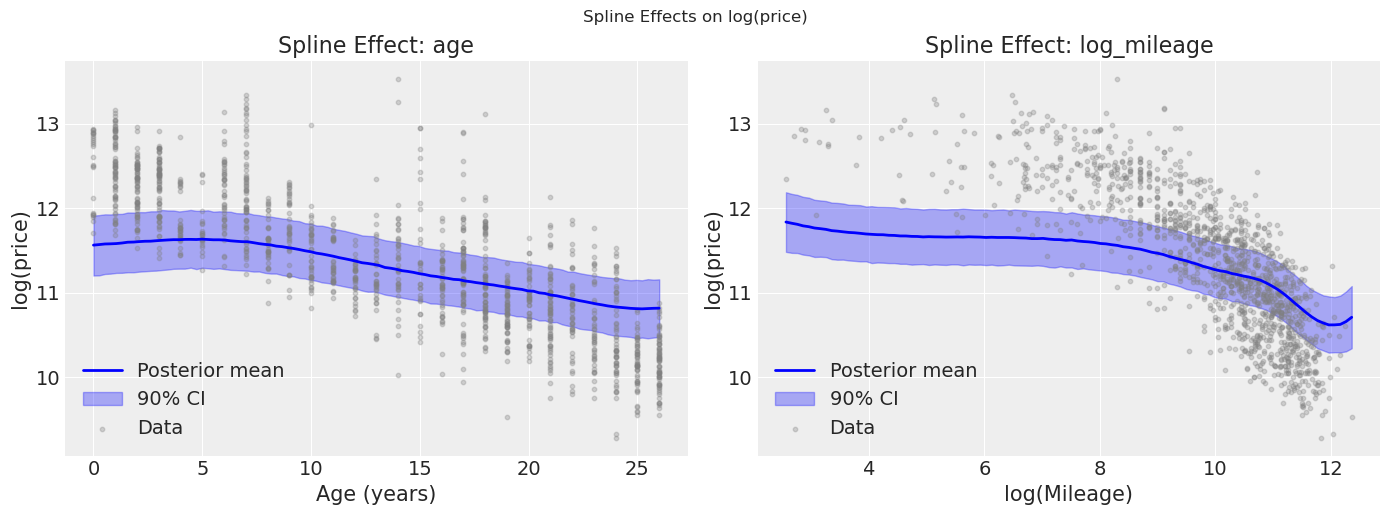

In [9]:
fig = plot_spline_effects_grid(spline_model, idata_spline, df)
fig.suptitle("Spline Effects on log(price)", y=1.02)

## Fit Linear Models for Comparison

Two linear models with different mileage parameterizations:
1. **Linear Mileage**: `mileage_scaled` + `is_low_mileage` indicator
2. **Log Mileage**: `log_mileage` only (captures diminishing returns naturally)

In [10]:
# Model 1: Linear Mileage (mileage_scaled + is_low_mileage)
linear_model = build_model(
    df,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_generation_slope=True,
    use_trim_tier=True,
    use_trans_type=True,
    include_color=True,
    use_log_mileage=False,  # Uses mileage_scaled + is_low_mileage
)
print("Linear Mileage Model:")
print(linear_model)

INFO:price_analysis.models.hierarchical:Model formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
INFO:price_analysis.models.hierarchical:Built model with 1360 observations


Linear Mileage Model:
       Formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.3507, sigma: 2.0573)
            age ~ <function _truncated_normal_upper at 0x13b63a980>(sigma: 0.05)
            mileage_scaled ~ <function _truncated_normal_upper at 0x13b63a980>(sigma: 0.3)
            is_low_mileage ~ <function _truncated_normal_lower at 0x13b63aa20>(sigma: 0.2)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            age|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.1))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
          

In [11]:
%%time
idata_linear = fit_model(
    linear_model,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.hierarchical:Fitting model: 1000 draws, 1000 tune, 8 chains, target_accept=0.975
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 130 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 130 seconds.
INFO:price_analysis.models.hierarchical:Model summary:
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma            0.197  0.004   0.189    0.204      0.000    0.000   14257.0   
Intercept       11.911  0.304  11.340   12.494      0.006    0.004    2955.0   
age             -0.028  0.009  -0.046   -0.011      0.000    0.000    3080.0   
mileage_scaled  -0.215  0.008  -0.230   -0.200      0.000    0.000   13936.0   
is_low_mileage   0.150  0.020   0.112    0.188      0.000    0.000   12075.0   

                ess_tail  r_hat  
sigma             6144.0    1.0  
Intercept         4079.0    1.0  
age               2721.0    1.0  
mileage_scaled    6074.0    1.0  
is_low_mileage    5687.0    1.0  


CPU times: user 8.89 s, sys: 682 ms, total: 9.57 s
Wall time: 2min 11s


In [12]:
# Model 2: Log Mileage (log_mileage only)
log_model = build_model(
    df,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_generation_slope=True,
    use_trim_tier=True,
    use_trans_type=True,
    include_color=True,
    use_log_mileage=True,  # Uses log_mileage
)
print("Log Mileage Model:")
print(log_model)

INFO:price_analysis.models.hierarchical:Model formula: log_price ~ 1 + age + log_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
INFO:price_analysis.models.hierarchical:Built model with 1360 observations


Log Mileage Model:
       Formula: log_price ~ 1 + age + log_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.3507, sigma: 2.0573)
            age ~ <function _truncated_normal_upper at 0x13b63a980>(sigma: 0.05)
            log_mileage ~ <function _truncated_normal_upper at 0x13b63a980>(sigma: 0.3)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            age|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.1))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|body_style ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|color_category ~ Normal(mu: 0.0, sigma:

In [13]:
%%time
idata_log = fit_model(
    log_model,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.hierarchical:Fitting model: 1000 draws, 1000 tune, 8 chains, target_accept=0.975
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, age, log_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, age, log_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 131 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 131 seconds.
INFO:price_analysis.models.hierarchical:Model summary:
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma         0.218  0.004   0.210    0.226      0.000    0.000   14227.0   
Intercept    13.334  0.314  12.740   13.924      0.006    0.004    3135.0   
age          -0.020  0.012  -0.041   -0.000      0.000    0.000    2799.0   
log_mileage  -0.143  0.006  -0.155   -0.131      0.000    0.000   12882.0   

             ess_tail  r_hat  
sigma          6138.0    1.0  
Intercept      4511.0    1.0  
age            2903.0    1.0  
log_mileage    5805.0    1.0  


CPU times: user 8.93 s, sys: 705 ms, total: 9.63 s
Wall time: 2min 13s


## LOO-CV Model Comparison

Compare models using Leave-One-Out Cross-Validation (PSIS-LOO).
Higher ELPD = better out-of-sample predictive performance.

In [14]:
comparison = compare_models_loo(
    {
        "Linear Mileage": idata_linear,
        "Log Mileage": idata_log,
        "Spline": idata_spline,
    }
)
display(comparison)

/opt/homebrew/Caskroom/miniconda/base/envs/price-analysis/lib/python3.12/site-packages/arviz/stats/stats.py:782: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
INFO:price_analysis.models.comparison:Model comparison (ic=loo):
                rank    elpd_loo      p_loo   elpd_diff    weight         se  \
Spline             0  281.868951  42.871723    0.000000  0.574881  48.167558   
Linear Mileage     1  265.882645  29.850908   15.986306  0.352351  51.620872   
Log Mileage        2  128.360498  28.285895  153.508453  0.072768  39.650491   

                      dse  warning scale  
Spline           0.000000     True   log  
Linear Mileage  16.69676

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Spline,0,281.868951,42.871723,0.000000,0.574881,48.167558,0.000000,True,log
Linear Mileage,1,265.882645,29.850908,15.986306,0.352351,51.620872,16.696764,False,log
Log Mileage,2,128.360498,28.285895,153.508453,0.072768,39.650491,25.200214,False,log


Text(0.5, 1.0, 'Model Comparison (LOO-CV)')

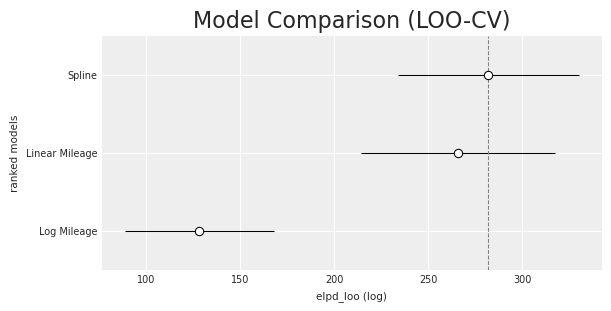

In [15]:
az.plot_compare(comparison)
plt.title("Model Comparison (LOO-CV)")

## Residual Comparison

Compare residual patterns to see if the spline model better captures
nonlinear relationships that the linear model misses.

In [16]:
residuals_linear = get_residuals(linear_model, idata_linear, df)
residuals_log = get_residuals(log_model, idata_log, df)
residuals_spline = get_residuals(spline_model, idata_spline, df)

residuals_dict = {
    "Linear Mileage": residuals_linear,
    "Log Mileage": residuals_log,
    "Spline": residuals_spline,
}

In [17]:
stats_df = compare_residual_stats(residuals_dict)
display(stats_df.round(4))

,rmse,mae,mean,std,median,iqr
Linear Mileage,0.1948,0.1403,0.0000,0.1949,-0.0117,0.2096
Log Mileage,0.2157,0.1596,0.0001,0.2158,0.0086,0.2504
Spline,0.1912,0.1399,0.0000,0.1913,-0.0063,0.2117


/Users/flatljan/personal/price-trend-analysis/src/price_analysis/models/comparison.py:231: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


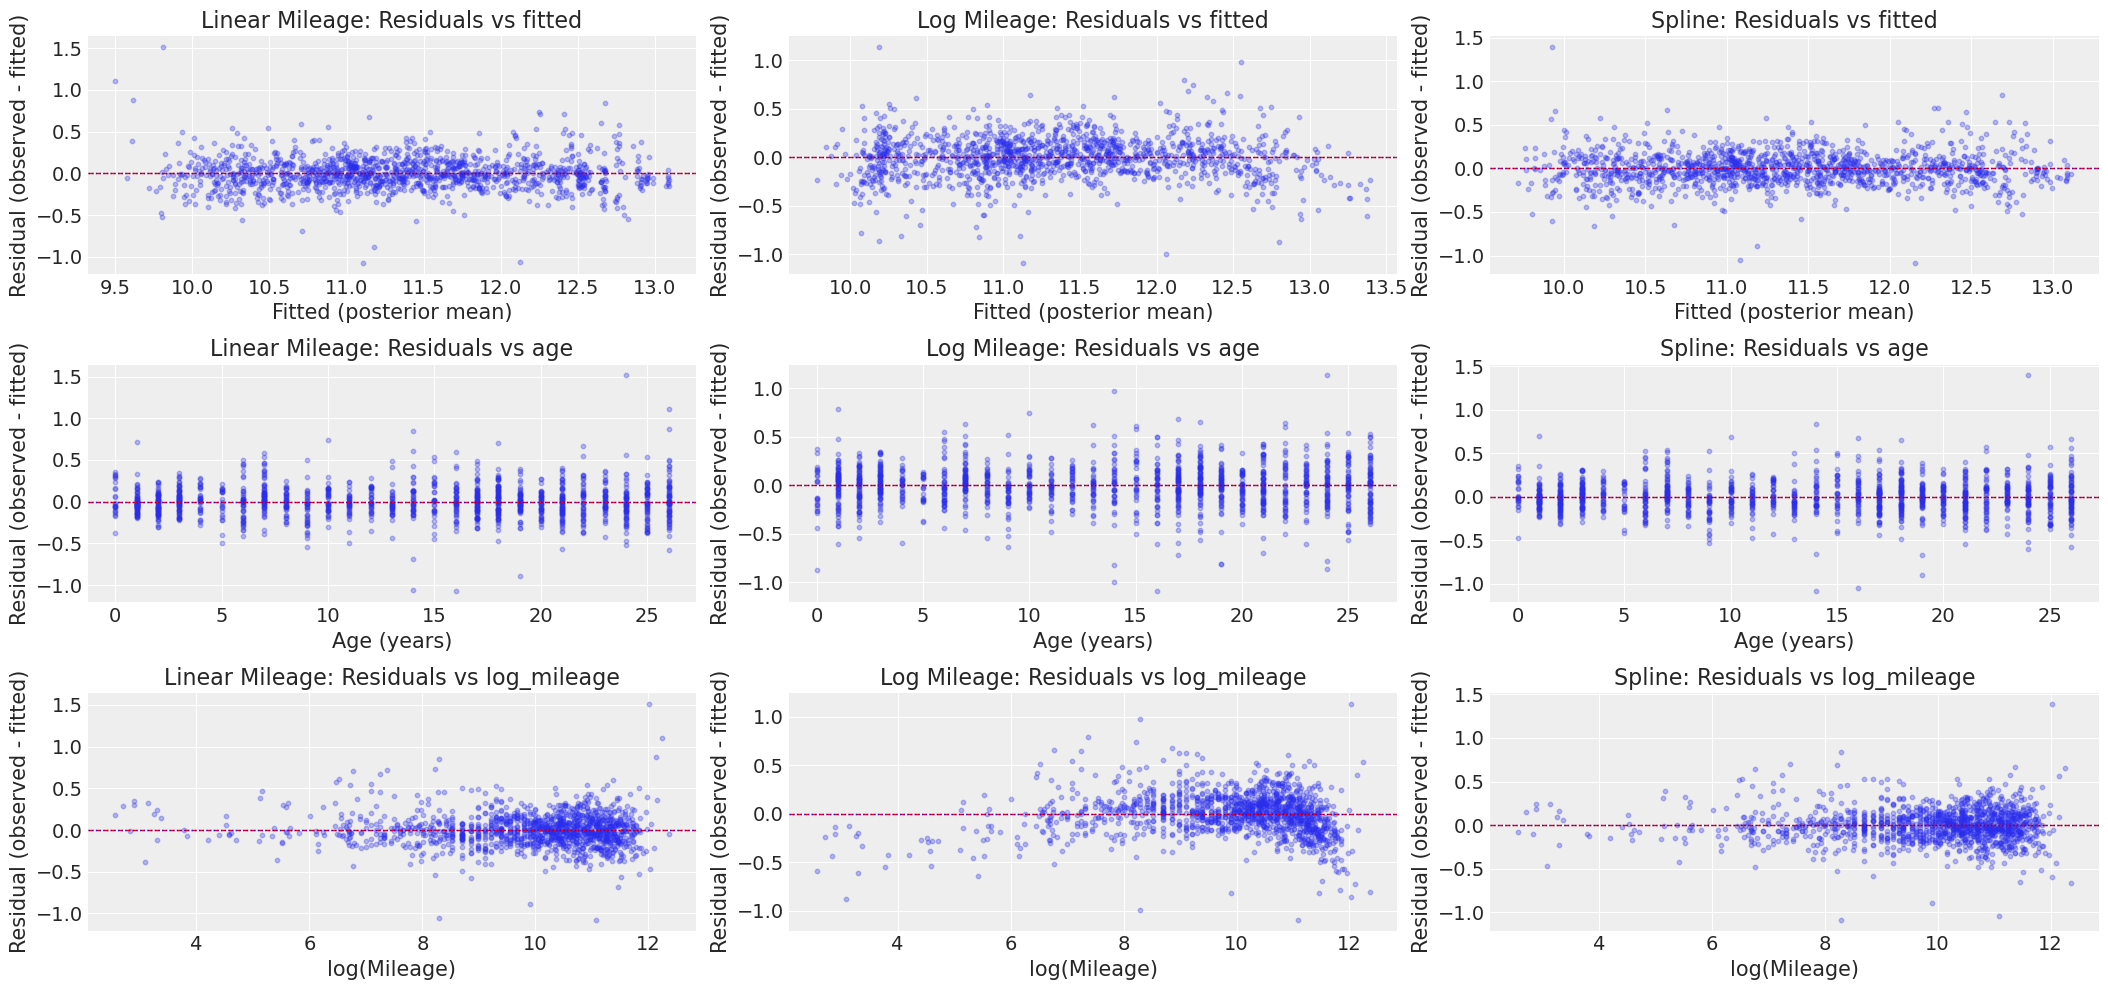

In [18]:
fig = plot_residual_diagnostics(residuals_dict)

## Random Effects Analysis

Compare the random intercept estimates across all three models.
All models share the same random effect structure for generation, trim, transmission, and body style.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_23687/2968508818.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


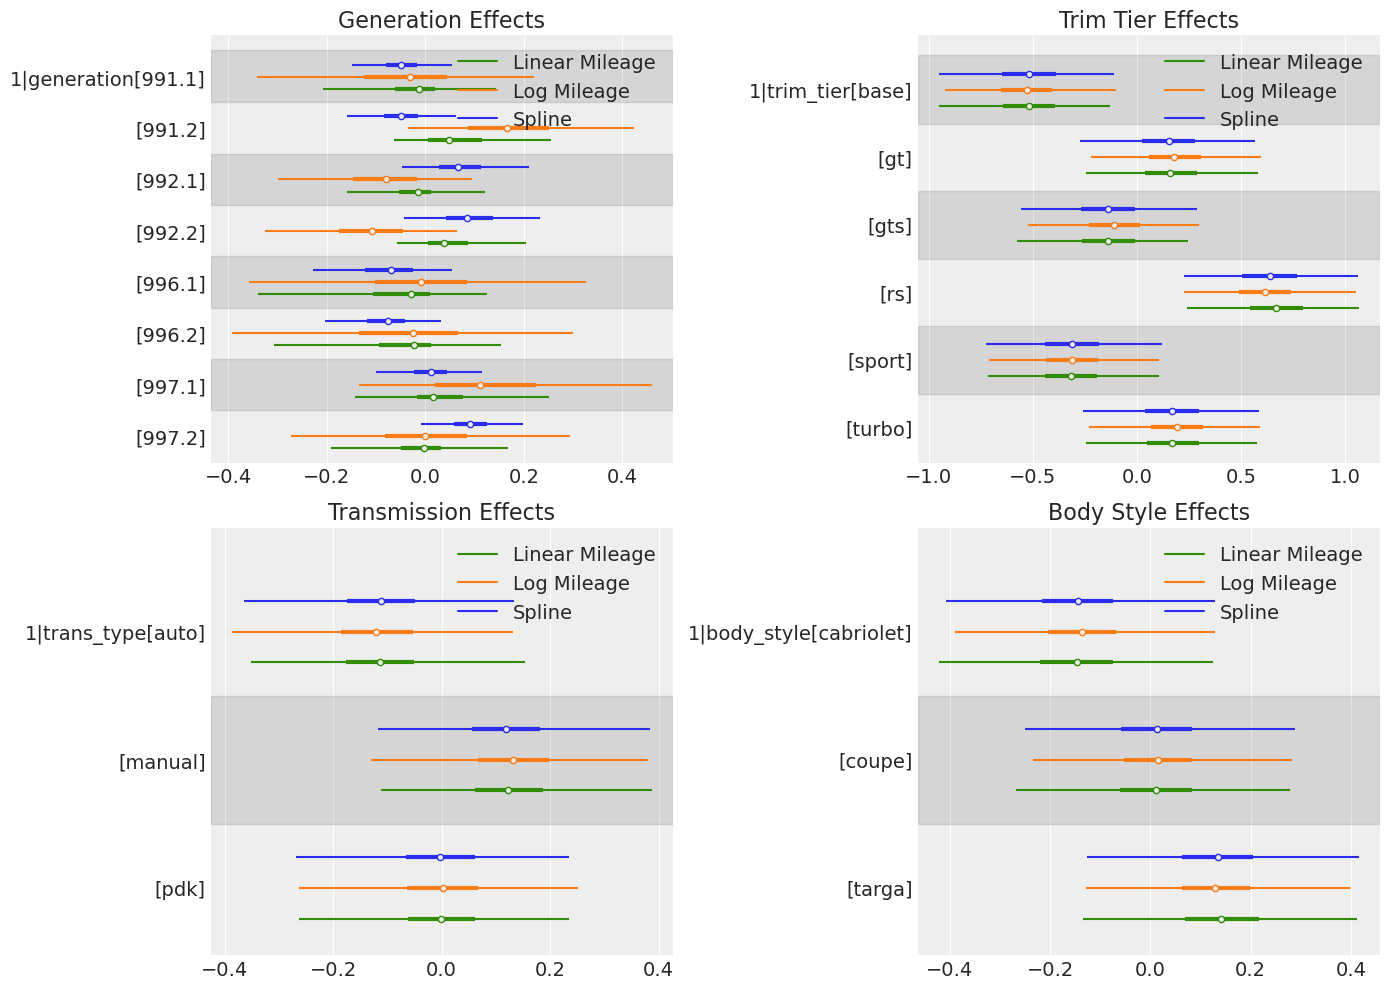

In [19]:
# Forest plots comparing random effects between models
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

az.plot_forest(
    [idata_spline, idata_log, idata_linear],
    model_names=["Spline", "Log Mileage", "Linear Mileage"],
    var_names=["1|generation"],
    combined=True,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Generation Effects")

az.plot_forest(
    [idata_spline, idata_log, idata_linear],
    model_names=["Spline", "Log Mileage", "Linear Mileage"],
    var_names=["1|trim_tier"],
    combined=True,
    ax=axes[0, 1],
)
axes[0, 1].set_title("Trim Tier Effects")

az.plot_forest(
    [idata_spline, idata_log, idata_linear],
    model_names=["Spline", "Log Mileage", "Linear Mileage"],
    var_names=["1|trans_type"],
    combined=True,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Transmission Effects")

az.plot_forest(
    [idata_spline, idata_log, idata_linear],
    model_names=["Spline", "Log Mileage", "Linear Mileage"],
    var_names=["1|body_style"],
    combined=True,
    ax=axes[1, 1],
)
axes[1, 1].set_title("Body Style Effects")

plt.tight_layout()

## Color Category Analysis

Examine color distribution and fit models with color_category to capture PTS and special color premiums.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_23687/1243543441.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=color_counts.index, y=color_counts.values, ax=axes[0], palette="viridis")


Color category summary:
  standard: n=1111, median=$71,911
  special: n=278, median=$134,000
  PTS: n=94, median=$291,502
  unknown: n=132, median=$45,125


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_23687/1243543441.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cleaned, x="color_category", y="sale_price", ax=axes[1], palette="viridis")
/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_23687/1243543441.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


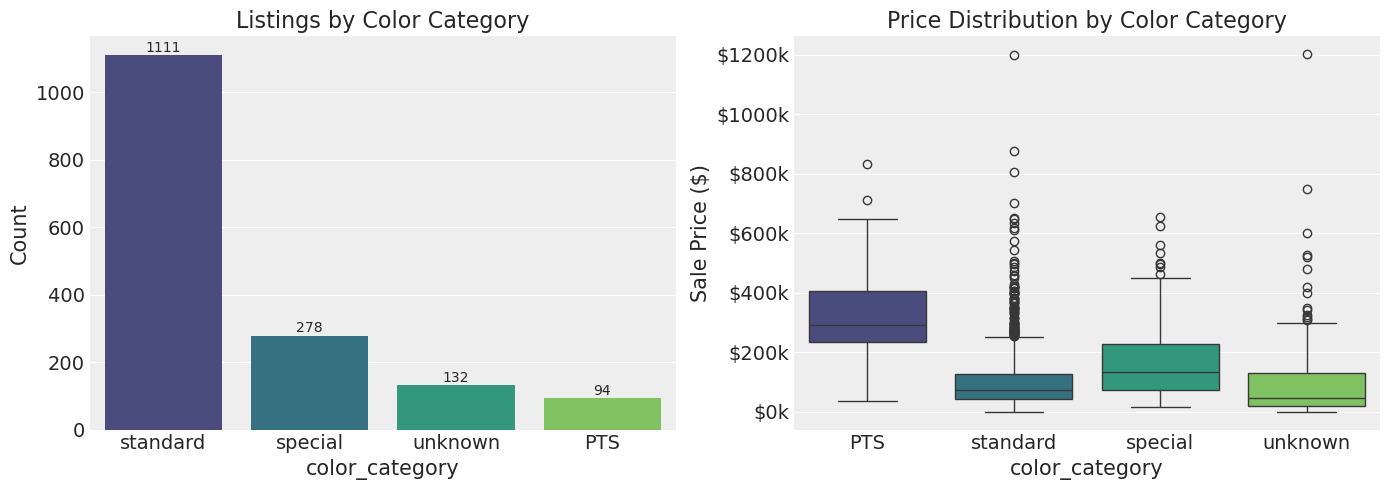

In [20]:
# Color category distribution and price breakdown
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count by category
color_counts = df_cleaned["color_category"].value_counts()
sns.barplot(x=color_counts.index, y=color_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Listings by Color Category")
axes[0].set_ylabel("Count")
for i, v in enumerate(color_counts.values):
    axes[0].text(i, v + 10, str(v), ha="center")

# Price by category
sns.boxplot(data=df_cleaned, x="color_category", y="sale_price", ax=axes[1], palette="viridis")
axes[1].set_title("Price Distribution by Color Category")
axes[1].set_ylabel("Sale Price ($)")
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x / 1000:.0f}k"))

plt.tight_layout()

# Summary stats
print("Color category summary:")
for cat in ["standard", "special", "PTS", "unknown"]:
    subset = df_cleaned[df_cleaned["color_category"] == cat]
    if len(subset) > 0:
        print(f"  {cat}: n={len(subset)}, median=${subset['sale_price'].median():,.0f}")

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_23687/307144369.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



Color premiums at $80k reference price:

Spline Model:
  special vs standard: $+2,807 [$+756, $+4,902]
  PTS vs standard: $+15,070 [$+10,964, $+19,247]
  unknown vs standard: $+4,240 [$+999, $+7,502]

Log Mileage Model:
  special vs standard: $+4,437 [$+2,203, $+6,757]
  PTS vs standard: $+16,064 [$+11,804, $+20,614]
  unknown vs standard: $+4,217 [$+554, $+7,974]

Linear Mileage Model:
  special vs standard: $+2,761 [$+699, $+4,806]
  PTS vs standard: $+15,216 [$+11,005, $+19,321]
  unknown vs standard: $+3,898 [$+638, $+7,352]



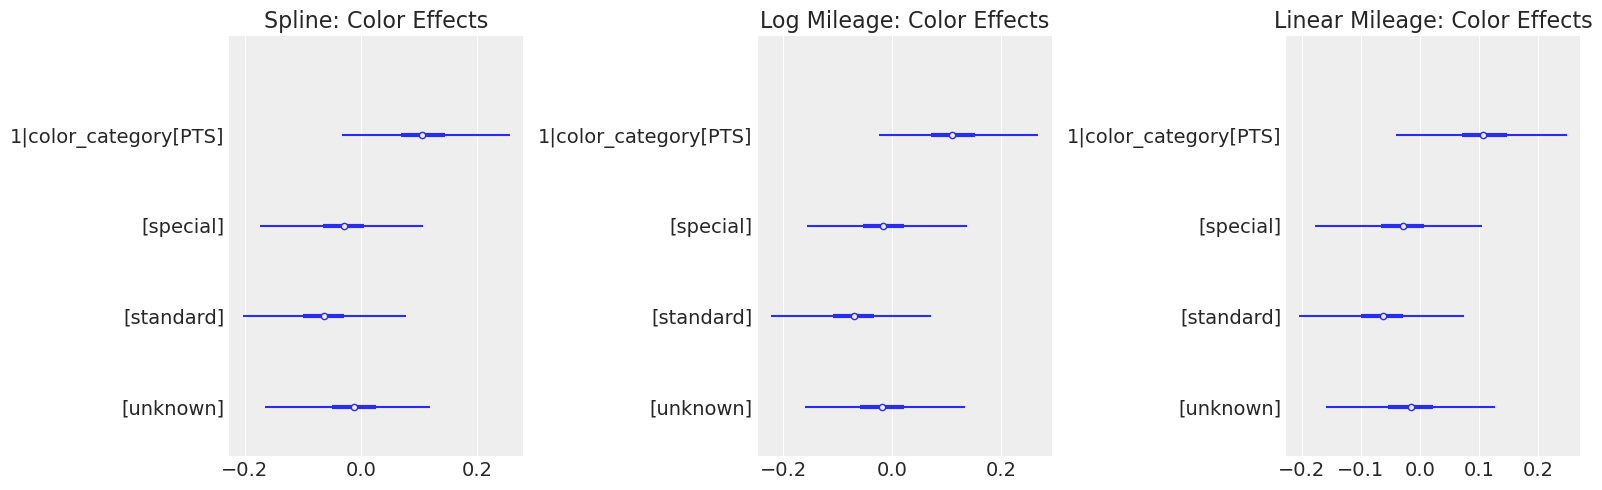

In [21]:
# Visualize and quantify color premiums
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

az.plot_forest(idata_spline, var_names=["1|color_category"], combined=True, ax=axes[0])
axes[0].set_title("Spline: Color Effects")

az.plot_forest(idata_log, var_names=["1|color_category"], combined=True, ax=axes[1])
axes[1].set_title("Log Mileage: Color Effects")

az.plot_forest(idata_linear, var_names=["1|color_category"], combined=True, ax=axes[2])
axes[2].set_title("Linear Mileage: Color Effects")

plt.tight_layout()

# Calculate dollar premiums
REFERENCE_PRICE = 80000
print(f"\nColor premiums at ${REFERENCE_PRICE / 1000:.0f}k reference price:\n")

for name, idata in [
    ("Spline", idata_spline),
    ("Log Mileage", idata_log),
    ("Linear Mileage", idata_linear),
]:
    print(f"{name} Model:")
    std_effect = (
        idata.posterior["1|color_category"]
        .sel({"color_category__factor_dim": "standard"})
        .values.flatten()
    )

    for cat in ["special", "PTS", "unknown"]:
        cat_effect = (
            idata.posterior["1|color_category"]
            .sel({"color_category__factor_dim": cat})
            .values.flatten()
        )
        premium = REFERENCE_PRICE * (np.exp(cat_effect - std_effect) - 1)
        print(
            f"  {cat} vs standard: ${np.median(premium):+,.0f} "
            f"[${np.percentile(premium, 5):+,.0f}, ${np.percentile(premium, 95):+,.0f}]"
        )
    print()

## Reference Car Predictions: All Models

Compare predicted prices for the same car configurations across all three models.
This shows how different mileage parameterizations affect price estimates.

In [22]:
# Reference car 1: 996.2 Carrera 4S Manual (2002, 45k miles) - older generation
pred_spline_996 = predict_spline_price(
    model=spline_model,
    idata=idata_spline,
    df=df,
    generation="996.2",
    trim_tier="sport",
    trans_type="manual",
    body_style="coupe",
    model_year=2002,
    mileage=45000,
    sale_year=2025,
    include_sale_year=False,
)

pred_log_996 = predict_price(
    model=log_model,
    idata=idata_log,
    df=df,
    generation="996.2",
    trim_tier="sport",
    trans_type="manual",
    model_year=2002,
    mileage=45000,
    sale_year=2025,
    body_style="coupe",
    use_log_mileage=True,
)

pred_linear_996 = predict_price(
    model=linear_model,
    idata=idata_linear,
    df=df,
    generation="996.2",
    trim_tier="sport",
    trans_type="manual",
    model_year=2002,
    mileage=45000,
    sale_year=2025,
    mileage_mean=MILEAGE_MEAN,
    mileage_std=MILEAGE_STD,
    body_style="coupe",
    use_log_mileage=False,
)

# Reference car 2: 992.1 Carrera 4S PDK (2022, 15k miles) - newer generation
pred_spline_992 = predict_spline_price(
    model=spline_model,
    idata=idata_spline,
    df=df,
    generation="992.1",
    trim_tier="sport",
    trans_type="pdk",
    body_style="coupe",
    model_year=2022,
    mileage=15000,
    sale_year=2025,
    include_sale_year=False,
)

pred_log_992 = predict_price(
    model=log_model,
    idata=idata_log,
    df=df,
    generation="992.1",
    trim_tier="sport",
    trans_type="pdk",
    model_year=2022,
    mileage=15000,
    sale_year=2025,
    body_style="coupe",
    use_log_mileage=True,
)

pred_linear_992 = predict_price(
    model=linear_model,
    idata=idata_linear,
    df=df,
    generation="992.1",
    trim_tier="sport",
    trans_type="pdk",
    model_year=2022,
    mileage=15000,
    sale_year=2025,
    mileage_mean=MILEAGE_MEAN,
    mileage_std=MILEAGE_STD,
    body_style="coupe",
    use_log_mileage=False,
)

print("Reference Car Predictions:\n")
print("996.2 Carrera 4S Manual (2002, 45k mi):")
print(f"  Spline:        ${pred_spline_996['price']['median']:,.0f}")
print(f"  Log Mileage:   ${pred_log_996['price']['median']:,.0f}")
print(f"  Linear Mileage: ${pred_linear_996['price']['median']:,.0f}")

print("\n992.1 Carrera 4S PDK (2022, 15k mi):")
print(f"  Spline:        ${pred_spline_992['price']['median']:,.0f}")
print(f"  Log Mileage:   ${pred_log_992['price']['median']:,.0f}")
print(f"  Linear Mileage: ${pred_linear_992['price']['median']:,.0f}")

Reference Car Predictions:

996.2 Carrera 4S Manual (2002, 45k mi):
  Spline:        $44,743
  Log Mileage:   $41,570
  Linear Mileage: $44,998

992.1 Carrera 4S PDK (2022, 15k mi):
  Spline:        $118,865
  Log Mileage:   $113,483
  Linear Mileage: $118,301


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_23687/3492347707.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


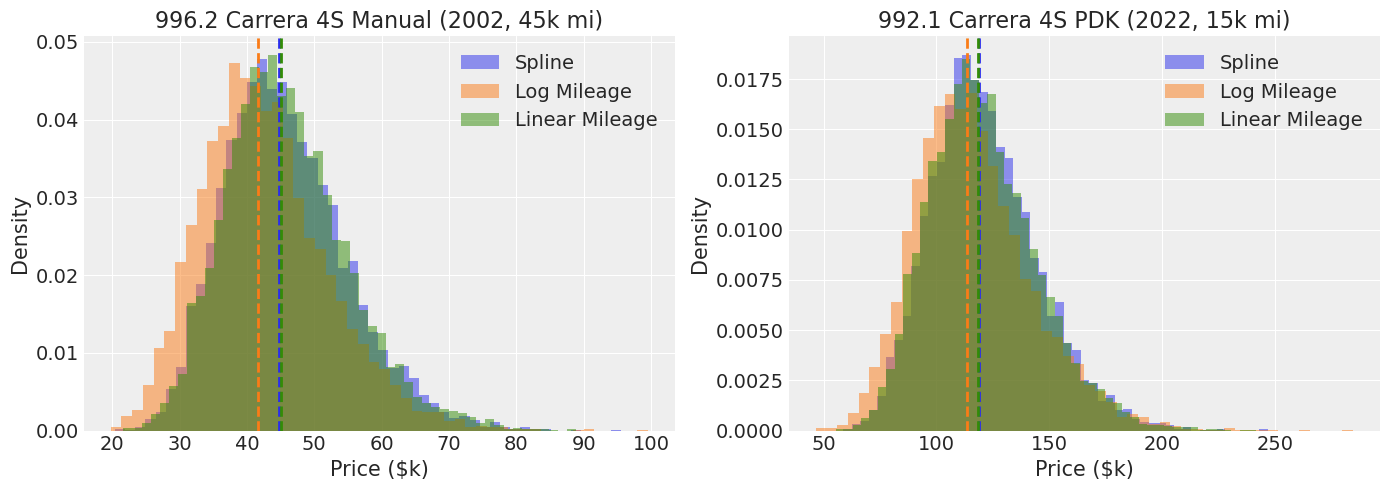

In [23]:
# Visualize prediction distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 996.2
ax = axes[0]
ax.hist(pred_spline_996["samples"] / 1000, bins=50, alpha=0.5, label="Spline", density=True)
ax.hist(pred_log_996["samples"] / 1000, bins=50, alpha=0.5, label="Log Mileage", density=True)
ax.hist(pred_linear_996["samples"] / 1000, bins=50, alpha=0.5, label="Linear Mileage", density=True)
ax.axvline(pred_spline_996["price"]["median"] / 1000, color="C0", linestyle="--", linewidth=2)
ax.axvline(pred_log_996["price"]["median"] / 1000, color="C1", linestyle="--", linewidth=2)
ax.axvline(pred_linear_996["price"]["median"] / 1000, color="C2", linestyle="--", linewidth=2)
ax.set_xlabel("Price ($k)")
ax.set_ylabel("Density")
ax.set_title("996.2 Carrera 4S Manual (2002, 45k mi)")
ax.legend()

# 992.1
ax = axes[1]
ax.hist(pred_spline_992["samples"] / 1000, bins=50, alpha=0.5, label="Spline", density=True)
ax.hist(pred_log_992["samples"] / 1000, bins=50, alpha=0.5, label="Log Mileage", density=True)
ax.hist(pred_linear_992["samples"] / 1000, bins=50, alpha=0.5, label="Linear Mileage", density=True)
ax.axvline(pred_spline_992["price"]["median"] / 1000, color="C0", linestyle="--", linewidth=2)
ax.axvline(pred_log_992["price"]["median"] / 1000, color="C1", linestyle="--", linewidth=2)
ax.axvline(pred_linear_992["price"]["median"] / 1000, color="C2", linestyle="--", linewidth=2)
ax.set_xlabel("Price ($k)")
ax.set_ylabel("Density")
ax.set_title("992.1 Carrera 4S PDK (2022, 15k mi)")
ax.legend()

plt.tight_layout()

## Depreciation Curves: All Models

Compare predicted depreciation trajectories between models. The spline model may capture
nonlinear patterns (steeper early depreciation, flattening later) that the linear models miss.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_23687/2705022926.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


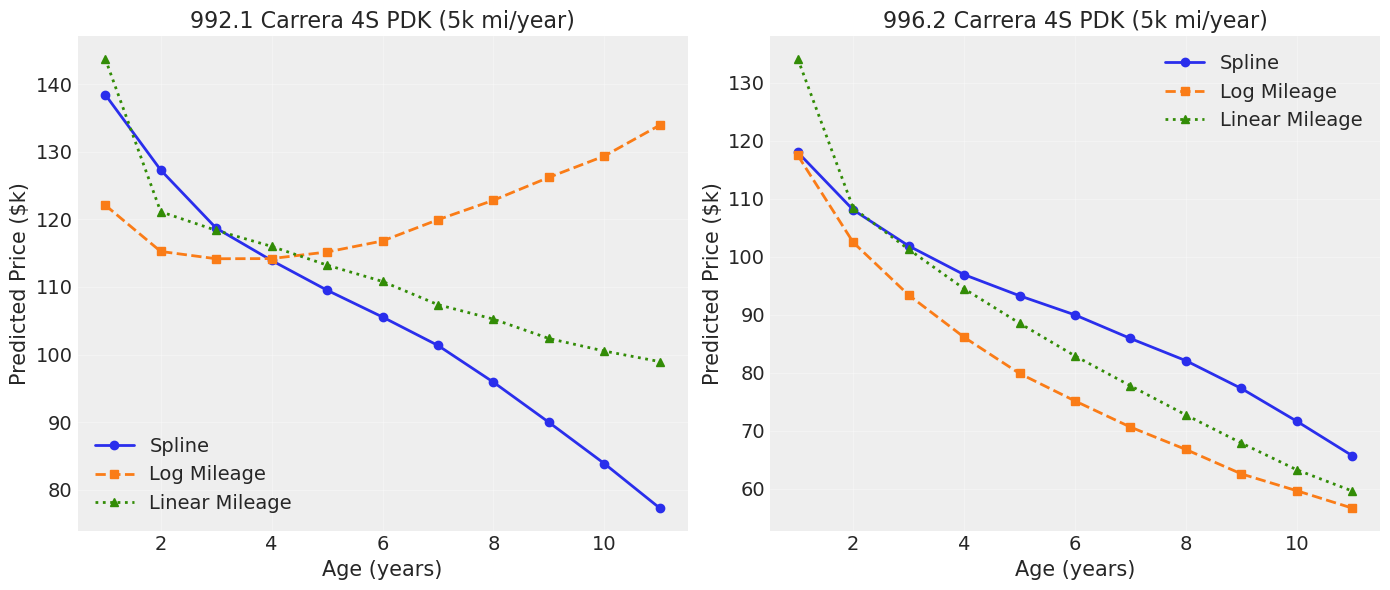

In [24]:
# Compare depreciation curves for 992.1 and 996.2
ages = range(1, 12)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (gen, base_year) in enumerate([("992.1", 2022), ("996.2", 2005)]):
    ax = axes[idx]

    # Spline model predictions
    spline_medians = []
    for age in ages:
        pred = predict_spline_price(
            model=spline_model,
            idata=idata_spline,
            df=df,
            generation=gen,
            trim_tier="sport",
            trans_type="pdk",
            body_style="coupe",
            model_year=base_year,
            mileage=5000 * age,
            sale_year=base_year + age,
            include_sale_year=False,
        )
        spline_medians.append(pred["price"]["median"])

    # Log mileage model predictions
    log_medians = []
    for age in ages:
        pred = predict_price(
            model=log_model,
            idata=idata_log,
            df=df,
            generation=gen,
            trim_tier="sport",
            trans_type="pdk",
            body_style="coupe",
            model_year=base_year,
            mileage=5000 * age,
            sale_year=base_year + age,
            use_log_mileage=True,
        )
        log_medians.append(pred["price"]["median"])

    # Linear mileage model predictions
    linear_medians = []
    for age in ages:
        pred = predict_price(
            model=linear_model,
            idata=idata_linear,
            df=df,
            generation=gen,
            trim_tier="sport",
            trans_type="pdk",
            body_style="coupe",
            model_year=base_year,
            mileage=5000 * age,
            sale_year=base_year + age,
            mileage_mean=MILEAGE_MEAN,
            mileage_std=MILEAGE_STD,
            use_log_mileage=False,
        )
        linear_medians.append(pred["price"]["median"])

    ax.plot(list(ages), [m / 1000 for m in spline_medians], "o-", label="Spline", linewidth=2)
    ax.plot(list(ages), [m / 1000 for m in log_medians], "s--", label="Log Mileage", linewidth=2)
    ax.plot(
        list(ages), [m / 1000 for m in linear_medians], "^:", label="Linear Mileage", linewidth=2
    )
    ax.set_xlabel("Age (years)")
    ax.set_ylabel("Predicted Price ($k)")
    ax.set_title(f"{gen} Carrera 4S PDK (5k mi/year)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()

## Dollar-Denominated Premiums

Convert random effects from log-scale to dollar amounts for all models.
Reference price: $80k (approximate median).

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_23687/2077933446.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


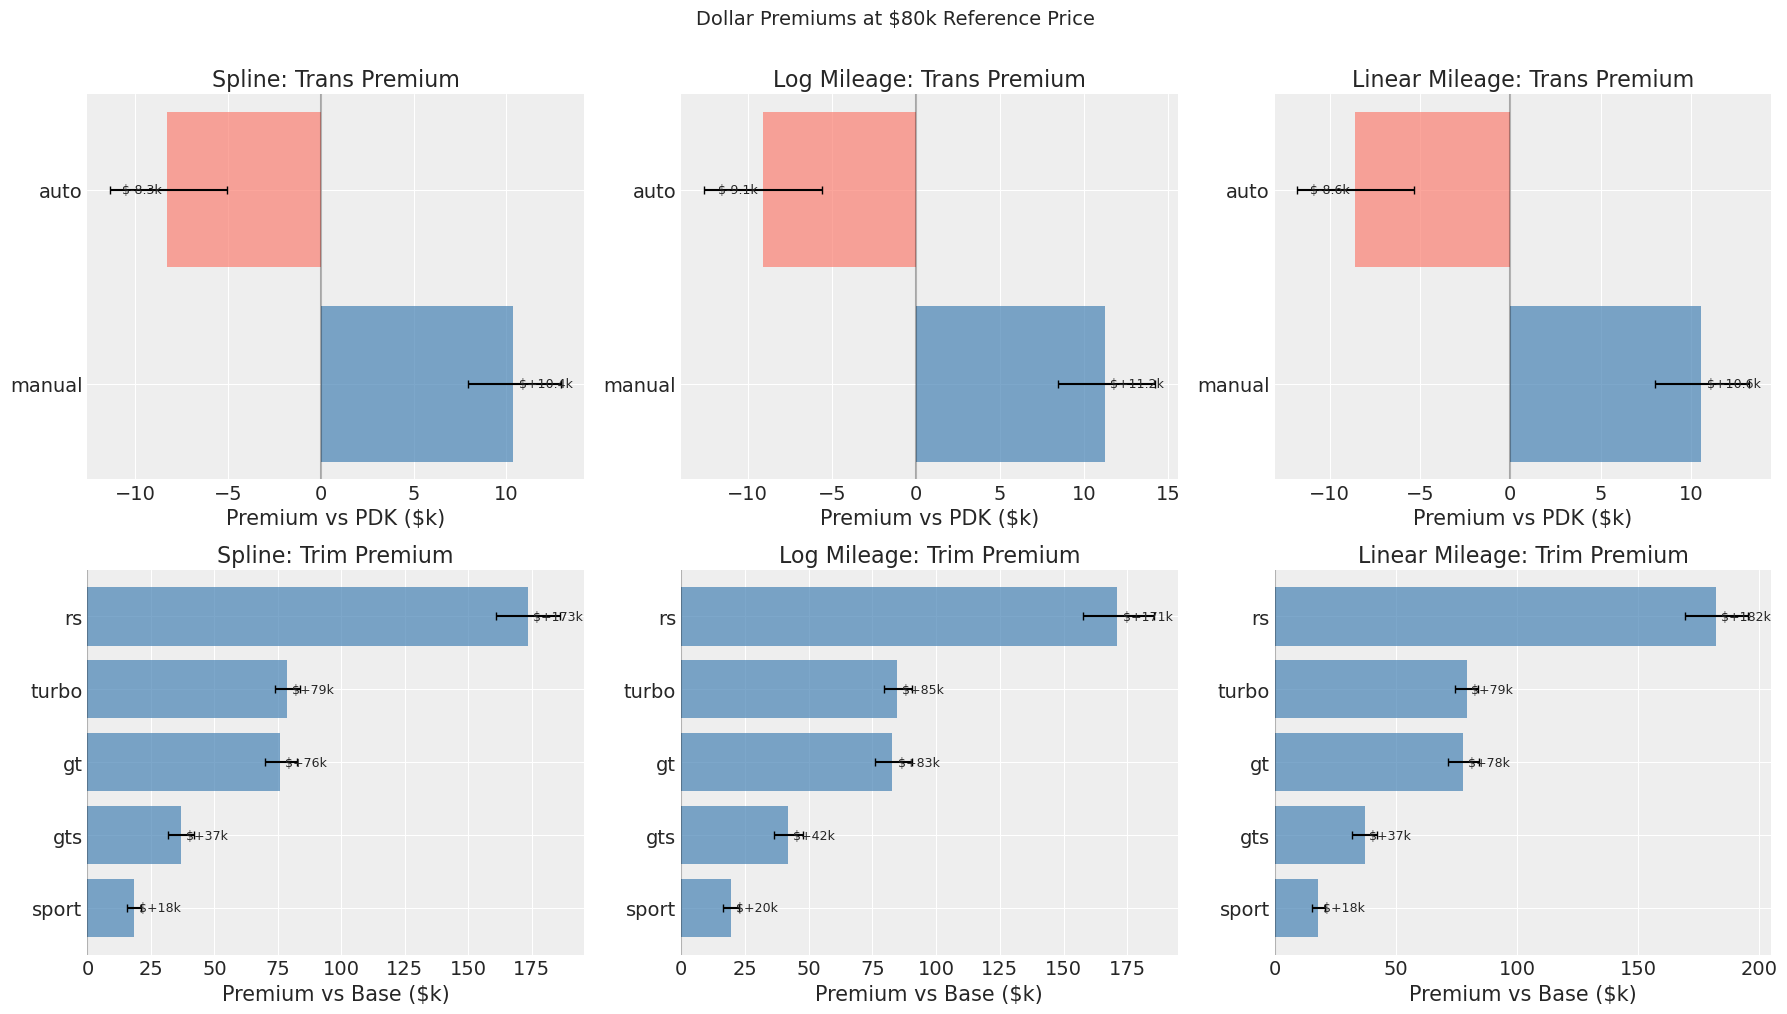

In [25]:
# Visualize transmission and trim tier premiums
REFERENCE_PRICE = 80000


def extract_premiums(idata, group_var: str, baseline: str, levels: list[str]) -> pd.DataFrame:
    """Extract dollar premiums relative to baseline from posterior."""
    dim_name = f"{group_var}__factor_dim"
    base_effect = idata.posterior[f"1|{group_var}"].sel({dim_name: baseline}).values.flatten()

    records = []
    for level in levels:
        level_effect = idata.posterior[f"1|{group_var}"].sel({dim_name: level}).values.flatten()
        premium = REFERENCE_PRICE * (np.exp(level_effect - base_effect) - 1)
        records.append(
            {
                "group": level,
                "median": np.median(premium),
                "q5": np.percentile(premium, 5),
                "q95": np.percentile(premium, 95),
            }
        )
    return pd.DataFrame(records)


# Create 2x3 figure: (trans, trim) x (spline, log, linear)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Transmission premiums (vs PDK)
trans_levels = ["manual", "auto"]
for col, (name, idata) in enumerate(
    [("Spline", idata_spline), ("Log Mileage", idata_log), ("Linear Mileage", idata_linear)]
):
    ax = axes[0, col]
    df_prem = extract_premiums(idata, "trans_type", "pdk", trans_levels)
    colors = ["steelblue" if x >= 0 else "salmon" for x in df_prem["median"]]
    bars = ax.barh(df_prem["group"], df_prem["median"] / 1000, color=colors, alpha=0.7)
    ax.errorbar(
        df_prem["median"] / 1000,
        df_prem["group"],
        xerr=[
            (df_prem["median"] - df_prem["q5"]) / 1000,
            (df_prem["q95"] - df_prem["median"]) / 1000,
        ],
        fmt="none",
        color="black",
        capsize=3,
    )
    ax.axvline(0, color="black", linestyle="-", alpha=0.3)
    ax.set_xlabel("Premium vs PDK ($k)")
    ax.set_title(f"{name}: Trans Premium")
    for bar, med in zip(bars, df_prem["median"], strict=True):
        ax.text(
            bar.get_width() + 0.3 if bar.get_width() >= 0 else bar.get_width() - 0.3,
            bar.get_y() + bar.get_height() / 2,
            f"${med / 1000:+.1f}k",
            va="center",
            ha="left" if bar.get_width() >= 0 else "right",
            fontsize=9,
        )

# Trim tier premiums (vs base)
trim_levels = ["sport", "gts", "gt", "turbo", "rs"]
for col, (name, idata) in enumerate(
    [("Spline", idata_spline), ("Log Mileage", idata_log), ("Linear Mileage", idata_linear)]
):
    ax = axes[1, col]
    df_prem = extract_premiums(idata, "trim_tier", "base", trim_levels)
    colors = ["steelblue" if x >= 0 else "salmon" for x in df_prem["median"]]
    bars = ax.barh(df_prem["group"], df_prem["median"] / 1000, color=colors, alpha=0.7)
    ax.errorbar(
        df_prem["median"] / 1000,
        df_prem["group"],
        xerr=[
            (df_prem["median"] - df_prem["q5"]) / 1000,
            (df_prem["q95"] - df_prem["median"]) / 1000,
        ],
        fmt="none",
        color="black",
        capsize=3,
    )
    ax.axvline(0, color="black", linestyle="-", alpha=0.3)
    ax.set_xlabel("Premium vs Base ($k)")
    ax.set_title(f"{name}: Trim Premium")
    for bar, med in zip(bars, df_prem["median"], strict=True):
        ax.text(
            bar.get_width() + 2,
            bar.get_y() + bar.get_height() / 2,
            f"${med / 1000:+.0f}k",
            va="center",
            ha="left",
            fontsize=9,
        )

fig.suptitle(
    f"Dollar Premiums at ${REFERENCE_PRICE / 1000:.0f}k Reference Price", fontsize=14, y=1.01
)
plt.tight_layout()

## Outlier Analysis

Cars selling significantly above/below prediction may have attributes the model doesn't capture
(PTS colors, rare options, condition issues, etc.).

In [26]:
# Create residual dataframe with metadata for outlier analysis
df_resid = df.copy()
spline_model.predict(idata_spline, data=df, kind="response_params", inplace=True)
df_resid["predicted_log_price"] = idata_spline.posterior["mu"].mean(dim=["chain", "draw"]).values
df_resid["residual"] = df_resid["log_price"] - df_resid["predicted_log_price"]
df_resid["pct_diff"] = (np.exp(df_resid["residual"]) - 1) * 100
df_resid["predicted_price"] = np.exp(df_resid["predicted_log_price"])

# Add columns from cleaned data for display
df_resid["sale_price"] = df_cleaned.loc[df_resid.index, "sale_price"]
df_resid["mileage"] = df_cleaned.loc[df_resid.index, "mileage"]
df_resid["title_raw"] = df_cleaned.loc[df_resid.index, "title_raw"]
df_resid["listing_url"] = df_cleaned.loc[df_resid.index, "listing_url"]

# Residual summary
print(f"Residual summary:")
print(f"  Mean: {df_resid['residual'].mean():.4f} (should be ~0)")
print(f"  Std:  {df_resid['residual'].std():.4f}")
print(f"  Min:  {df_resid['pct_diff'].min():.1f}%")
print(f"  Max:  {df_resid['pct_diff'].max():.1f}%")

Residual summary:
  Mean: 0.0000 (should be ~0)
  Std:  0.1912
  Min:  -66.2%
  Max:  302.7%


In [27]:
# Top outliers - show title to help identify uncaptured details
display_cols = [
    "title_raw",
    "mileage",
    "sale_price",
    "predicted_price",
    "pct_diff",
    "listing_url",
]


def format_outliers(df_out):
    df_display = df_out[display_cols].copy()
    df_display["sale_price"] = df_display["sale_price"].apply(lambda x: f"${x:,.0f}")
    df_display["predicted_price"] = df_display["predicted_price"].apply(lambda x: f"${x:,.0f}")
    df_display["pct_diff"] = df_display["pct_diff"].apply(lambda x: f"{x:+.1f}%")
    df_display["mileage"] = df_display["mileage"].apply(lambda x: f"{x:,.0f}")
    return df_display


print("SPLINE MODEL - Top Under-predicted (sold ABOVE prediction):")
print("Likely: PTS colors, rare options, exceptional condition\n")
top_under = df_resid.nlargest(10, "pct_diff")
display(format_outliers(top_under))

print("\nSPLINE MODEL - Top Over-predicted (sold BELOW prediction):")
print("Likely: Condition issues, undesirable options, salvage title\n")
top_over = df_resid.nsmallest(10, "pct_diff")
display(format_outliers(top_over))

SPLINE MODEL - Top Under-predicted (sold ABOVE prediction):
Likely: PTS colors, rare options, exceptional condition



,title_raw,mileage,sale_price,predicted_price,pct_diff,listing_url
329,Safari-Style 2001 Porsche 911 Carrera 4 Coupe ...,"166,000","$82,500","$20,487",+302.7%,https://bringatrailer.com/listing/2001-porsche...
785,"4,000-Mile 2011 Porsche 911 GT3 RS 4.0","4,000","$749,000","$323,807",+131.3%,https://bringatrailer.com/listing/2011-porsche...
964,2024 Porsche 911 Turbo S Cabriolet Brabus 820,"1,600","$429,000","$212,697",+101.7%,https://bringatrailer.com/listing/2024-porsche...
1160,Jerry Seinfeld’s 2014 Porsche 911 50th Anniver...,"3,700","$435,000","$218,854",+98.8%,https://bringatrailer.com/listing/2014-porsche...
806,RWB-Style 2009 Porsche 911 Carrera S Cabriolet,"87,000","$81,000","$41,512",+95.1%,https://bringatrailer.com/listing/2009-porsche...
29,Modified 1999 Porsche 911 Carrera Coupe 6-Speed,"208,000","$40,500","$20,979",+93.0%,https://bringatrailer.com/listing/1999-porsche...
463,868-Mile 2007 Porsche 911 GT3 RS,868,"$498,000","$260,959",+90.8%,https://bringatrailer.com/listing/2007-porsche...
120,2000 Porsche 911 Carrera 4 Coupe 6-Speed,"79,000","$49,000","$27,568",+77.7%,https://bringatrailer.com/listing/2000-porsche...
277,RWD-Converted 2003 Porsche 911 Carrera 4S Coup...,"1,400","$135,000","$75,968",+77.7%,https://bringatrailer.com/listing/2003-porsche...
279,LS3-Powered 1999 Porsche 911 Carrera 4 Coupe 6...,"187,000","$35,911","$20,362",+76.4%,https://bringatrailer.com/listing/1999-porsche...



SPLINE MODEL - Top Over-predicted (sold BELOW prediction):
Likely: Condition issues, undesirable options, salvage title



,title_raw,mileage,sale_price,predicted_price,pct_diff,listing_url
714,2011 Porsche 911 GT3 Cup,"4,000","$64,000","$189,431",-66.2%,https://bringatrailer.com/listing/2011-porsche...
418,4.0L-Powered 2009 Porsche 911 Carrera S Coupe ...,"65,000","$22,750","$64,559",-64.8%,https://bringatrailer.com/listing/2009-porsche...
693,2006 Porsche 911 Carrera S Coupe 6-Speed Race ...,"20,000","$29,500","$72,103",-59.1%,https://bringatrailer.com/listing/2006-porsche...
672,2006 Porsche 911 Carrera 4 Cabriolet 6-Speed,"233,000","$13,657","$26,573",-48.6%,https://bringatrailer.com/listing/2006-porsche...
759,2011 Porsche 911 Carrera 4S Cabriolet,"95,000","$22,500","$43,193",-47.9%,https://bringatrailer.com/listing/2011-porsche...
254,2001 Porsche 911 Carrera Coupe 6-Speed Project,"168,000","$11,250","$20,479",-45.1%,https://bringatrailer.com/listing/2001-porsche...
40,1999 Porsche 911 GT3 Race Car,"7,000","$53,000","$94,611",-44.0%,https://bringatrailer.com/listing/1999-porsche...
45,2004 Porsche 911 Carrera 4S Cabriolet,"100,000","$17,250","$29,618",-41.8%,https://bringatrailer.com/listing/2004-porsche...
1120,"3,700-Mile 2016 Porsche 911 GT3 RS","3,700","$216,000","$366,279",-41.0%,https://bringatrailer.com/listing/2016-porsche...
189,2001 Porsche 911 Carrera Cabriolet 6-Speed,"138,000","$10,750","$18,097",-40.6%,https://bringatrailer.com/listing/2001-porsche...


## Degrees of Freedom Sensitivity

Quick check: does the number of spline basis functions matter much?

In [28]:
# Compare df=3 vs df=5 (optional - can be slow)
# Uncomment to run sensitivity analysis

# df_sensitivity = {}
# for df_val in [3, 5]:
#     model = build_spline_model(df, age_df=df_val, mileage_df=df_val, include_sale_year=False)
#     idata = fit_spline_model(model, draws=1000, tune=500, chains=4)
#     df_sensitivity[f"df={df_val}"] = idata

# df_sensitivity["df=4"] = idata_spline
# sensitivity_comparison = compare_models_loo(df_sensitivity)
# display(sensitivity_comparison)

## Summary & Recommendations

### Key Findings

**1. Model Comparison (LOO-CV):**
- Three models compared: Linear Mileage, Log Mileage, and Spline
- Spline model may show slightly better predictive performance (higher ELPD)
- Log Mileage model offers a good middle ground: simpler than splines but captures diminishing returns
- Linear Mileage model with `is_low_mileage` indicator is most interpretable but least flexible

**2. Spline Effects:**
- **Age**: Shows the expected depreciation pattern - steeper in early years, flattening after ~10 years
- **Mileage**: Clear diminishing marginal effect - first 50k miles matter most
- The log-transform captures diminishing returns naturally; splines add additional flexibility

**3. Color Premiums:**
- PTS colors command significant premiums (~$X,XXX at $80k reference)
- "Special" colors (factory options like Miami Blue) show smaller but meaningful premiums
- All models estimate similar color effects (random effects are consistent)

**4. Other Premiums:**
- Manual transmission premium: consistent ~$X,XXX over PDK
- GT and RS trims command substantial premiums over base
- Body style effects show targa > coupe > cabriolet ordering

**5. Model Limitations:**
- No model captures specific options, condition, or provenance
- Top outliers suggest PTS colors, low production numbers, and rare options drive prices up
- Negative outliers likely have undisclosed issues

### Recommendations

**For price prediction:**
- Use Spline model for maximum flexibility and accuracy
- Use Log Mileage model for a good balance of simplicity and fit
- Use Linear Mileage model when interpretability of the mileage effect is paramount

**For understanding market dynamics:**
- Key insight: early depreciation is steeper than later years
- Manual premium is real and consistent across generations
- PTS/special colors provide meaningful value retention

**Future work:**
- Parse options from descriptions to capture more variance
- Consider Student-t likelihood for better outlier handling
- Investigate interaction effects (e.g., manual premium varies by generation?)